<a href="https://colab.research.google.com/github/clustercoder/pqc_bench/blob/main/QCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print("Python", sys.version)

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [2]:
!pip install --quiet kyber-py dilithium-py mceliece pypqc

In [3]:
!pip install oqs


In [4]:
!pip install liboqs-python


In [5]:
!git clone https://github.com/open-quantum-safe/liboqs-python.git
%cd liboqs-python
!pip install .
%cd ..


fatal: destination path 'liboqs-python' already exists and is not an empty directory.
/content/liboqs-python
Processing /content/liboqs-python
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for liboqs-python: filename=liboqs_python-0.14.0-py3-none-any.whl size=17951 sha256=a5226109ebb012923de5228ae2b1edf7fae350c373e29abef859e07fa92c1f1a
  Stored in directory: /root/.cache/pip/wheels/97/31/5b/9645fe9b387fd90cf50d2febb54ed27642dbdf4e154e9f5d8f
Successfully built liboqs-python
  Attempting uninstall: liboqs-python
    Found existing installation: liboqs-python 0.14.0
    Uninstalling liboqs-python-0.14.0:
      Successfully uninstalled liboqs-python-0.14.0
/content


In [6]:
import oqs

# Some builds hide the list under oqs.get_enabled_KEM_mechanisms
try:
    print("Available KEMs:", oqs.get_enabled_KEM_mechanisms())
except Exception as e:
    print("Alternate name failed:", e)
    try:
        print("Available KEMs:", oqs.get_supported_KEM_mechanisms())
    except Exception as e2:
        print("Alternate name failed:", e2)


Alternate name failed: module 'oqs' has no attribute 'get_enabled_KEM_mechanisms'
Alternate name failed: module 'oqs' has no attribute 'get_supported_KEM_mechanisms'


In [7]:
import oqs
print(dir(oqs))


['KeyEncapsulation', 'MechanismNotEnabledError', 'MechanismNotSupportedError', 'OQS_SUCCESS', 'OQS_VERSION', 'Signature', 'StatefulSignature', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'get_enabled_kem_mechanisms', 'get_enabled_sig_mechanisms', 'get_enabled_stateful_sig_mechanisms', 'get_supported_kem_mechanisms', 'get_supported_sig_mechanisms', 'get_supported_stateful_sig_mechanisms', 'is_kem_enabled', 'is_sig_enabled', 'native', 'oqs', 'oqs_python_version', 'oqs_version', 'sig_supports_context']


In [8]:
import oqs

print("Testing Kyber512 KEM...")

# Create Kyber512 KEM instance
kem = oqs.KeyEncapsulation("Kyber512")

# Generate keypair
public_key = kem.generate_keypair()

# Encapsulate (sender)
ciphertext, shared_secret_sender = kem.encap_secret(public_key)

# Decapsulate (receiver)
shared_secret_receiver = kem.decap_secret(ciphertext)

# Print results
print("✅ Kyber512 test successful!")
print("Shared secrets match:", shared_secret_sender == shared_secret_receiver)
print("Public key size:", len(public_key), "bytes")
print("Ciphertext size:", len(ciphertext), "bytes")


Testing Kyber512 KEM...
✅ Kyber512 test successful!
Shared secrets match: True
Public key size: 800 bytes
Ciphertext size: 768 bytes


In [9]:
import oqs

print("Testing Dilithium2 digital signature...")

sig = oqs.Signature("Dilithium2")

# Generate keypair
public_key = sig.generate_keypair()

# Message to sign
message = b"Quantum-resistant cryptography project test message"

# Sign the message
signature = sig.sign(message)

# Verify the signature
is_valid = sig.verify(message, signature, public_key)

# Output
print("✅ Dilithium2 signature test successful!")
print("Signature valid:", is_valid)
print("Public key size:", len(public_key), "bytes")
print("Signature size:", len(signature), "bytes")


Testing Dilithium2 digital signature...
✅ Dilithium2 signature test successful!
Signature valid: True
Public key size: 1312 bytes
Signature size: 2420 bytes


In [10]:
import oqs

print("Testing Classic McEliece (code-based KEM)...")

# Try a smaller McEliece variant
kem_name = "Classic-McEliece-348864"

kem = oqs.KeyEncapsulation(kem_name)

# Generate keypair
public_key = kem.generate_keypair()

# Encapsulate (sender)
ciphertext, shared_secret_sender = kem.encap_secret(public_key)

# Decapsulate (receiver)
shared_secret_receiver = kem.decap_secret(ciphertext)

# Print results
print(f"✅ {kem_name} test successful!")
print("Shared secrets match:", shared_secret_sender == shared_secret_receiver)
print("Public key size:", len(public_key), "bytes")
print("Ciphertext size:", len(ciphertext), "bytes")


Testing Classic McEliece (code-based KEM)...
✅ Classic-McEliece-348864 test successful!
Shared secrets match: True
Public key size: 261120 bytes
Ciphertext size: 96 bytes


In [11]:
import oqs
import time
import pandas as pd

# List of algorithms to benchmark
algorithms = [
    {"name": "Kyber512", "type": "KEM"},
    {"name": "Dilithium2", "type": "Signature"},
    {"name": "Classic-McEliece-348864", "type": "KEM"}
]

results = []

for alg in algorithms:
    print(f"\n🔹 Testing {alg['name']} ({alg['type']}) ...")
    start_time = time.time()

    if alg["type"] == "KEM":
        kem = oqs.KeyEncapsulation(alg["name"])
        public_key = kem.generate_keypair()

        t1 = time.time()
        ciphertext, shared_secret_sender = kem.encap_secret(public_key)
        t2 = time.time()
        shared_secret_receiver = kem.decap_secret(ciphertext)
        t3 = time.time()

        runtime = t3 - start_time
        results.append({
            "Algorithm": alg["name"],
            "Category": "KEM",
            "KeyGen Time (s)": round(t1 - start_time, 4),
            "Encap Time (s)": round(t2 - t1, 4),
            "Decap Time (s)": round(t3 - t2, 4),
            "Total Runtime (s)": round(runtime, 4),
            "Public Key (bytes)": len(public_key),
            "Ciphertext (bytes)": len(ciphertext),
            "Shared Secret Match": shared_secret_sender == shared_secret_receiver
        })

    elif alg["type"] == "Signature":
        sig = oqs.Signature(alg["name"])
        public_key = sig.generate_keypair()

        message = b"Quantum-resistant benchmark message"
        t1 = time.time()
        signature = sig.sign(message)
        t2 = time.time()
        valid = sig.verify(message, signature, public_key)
        t3 = time.time()

        runtime = t3 - start_time
        results.append({
            "Algorithm": alg["name"],
            "Category": "Signature",
            "KeyGen Time (s)": round(t1 - start_time, 4),
            "Sign Time (s)": round(t2 - t1, 4),
            "Verify Time (s)": round(t3 - t2, 4),
            "Total Runtime (s)": round(runtime, 4),
            "Public Key (bytes)": len(public_key),
            "Signature (bytes)": len(signature),
            "Valid Signature": valid
        })

# Convert to DataFrame
df = pd.DataFrame(results)

print("\n✅ Benchmark completed successfully!\n")
display(df)



🔹 Testing Kyber512 (KEM) ...

🔹 Testing Dilithium2 (Signature) ...

🔹 Testing Classic-McEliece-348864 (KEM) ...

✅ Benchmark completed successfully!



,Algorithm,Category,KeyGen Time (s),Encap Time (s),Decap Time (s),Total Runtime (s),Public Key (bytes),Ciphertext (bytes),Shared Secret Match,Sign Time (s),Verify Time (s),Signature (bytes),Valid Signature
0,Kyber512,KEM,0.0003,0.0001,0.0000,0.0005,800,768.0,True,NaN,NaN,NaN,NaN
1,Dilithium2,Signature,0.0002,NaN,NaN,0.0005,1312,NaN,NaN,0.0002,0.0001,2420.0,True
2,Classic-McEliece-348864,KEM,0.0888,0.0003,0.0001,0.0893,261120,96.0,True,NaN,NaN,NaN,NaN


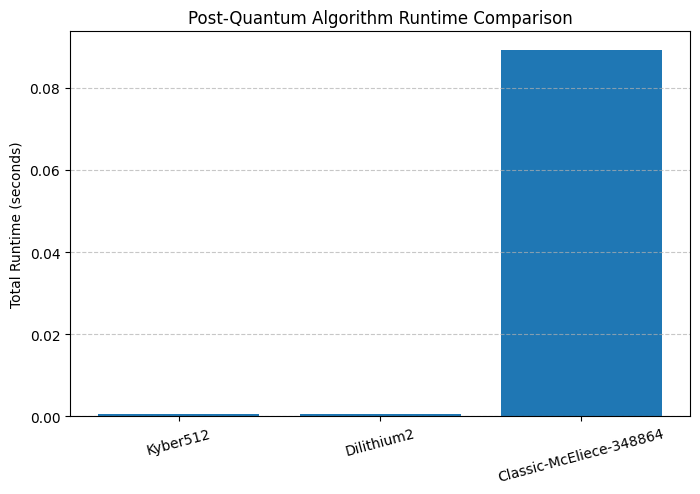

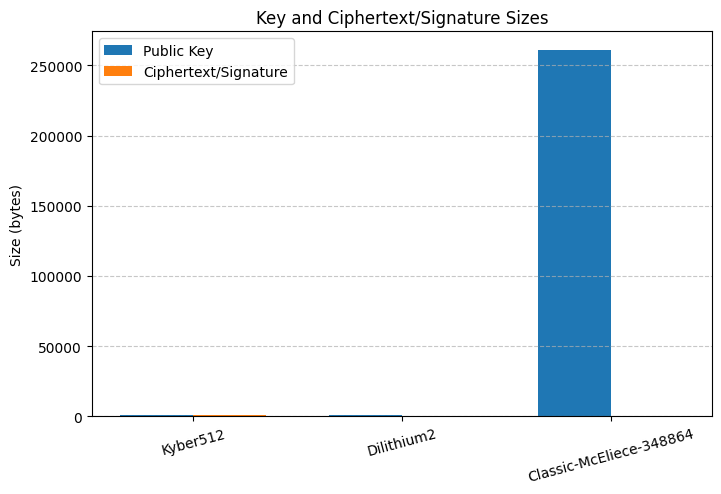

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Separate KEMs and Signatures
kem_df = df[df["Category"] == "KEM"]
sig_df = df[df["Category"] == "Signature"]

# --- 1️⃣ RUNTIME COMPARISON ---
plt.figure(figsize=(8,5))
x = np.arange(len(df))
plt.bar(x, df["Total Runtime (s)"])
plt.xticks(x, df["Algorithm"], rotation=15)
plt.ylabel("Total Runtime (seconds)")
plt.title("Post-Quantum Algorithm Runtime Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 2️⃣ KEY SIZE COMPARISON ---
plt.figure(figsize=(8,5))
x = np.arange(len(df))
bar_width = 0.35

if "Ciphertext (bytes)" in df.columns:
    plt.bar(x - bar_width/2, df["Public Key (bytes)"], bar_width, label="Public Key")
    plt.bar(x + bar_width/2, df.get("Ciphertext (bytes)", df.get("Signature (bytes)", 0)), bar_width, label="Ciphertext/Signature")
else:
    plt.bar(x - bar_width/2, df["Public Key (bytes)"], bar_width, label="Public Key")
    plt.bar(x + bar_width/2, df["Signature (bytes)"], bar_width, label="Signature")

plt.xticks(x, df["Algorithm"], rotation=15)
plt.ylabel("Size (bytes)")
plt.title("Key and Ciphertext/Signature Sizes")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [14]:
# --- Clean reinstall of Qiskit 1.x (compatible version) ---
!pip uninstall -y qiskit qiskit-terra qiskit-aer qiskit-ibmq-provider
!pip install -U qiskit==1.2.4 qiskit-aer==0.15.0
!pip show qiskit


Found existing installation: qiskit 2.2.2
Uninstalling qiskit-2.2.2:
  Successfully uninstalled qiskit-2.2.2
Found existing installation: qiskit-terra 0.46.3
Uninstalling qiskit-terra-0.46.3:
  Successfully uninstalled qiskit-terra-0.46.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: symengine
    Found existing installation: symengine 0.14.1
    Uninstalling symengine-0.14.1:
      Successfully uninstalled symengine-0.14.1
Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: dill, n

In [15]:
from qiskit import QuantumCircuit, transpile
print("✅ Qiskit imported successfully!")


✅ Qiskit imported successfully!


In [18]:
# ===============================================================
# ✅ FIXED QISKIT METRICS CELL
# Works with Qiskit 1.x (no Shor import required)
# Shows small Grover circuits and toy Shor-like scaling
# ===============================================================
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import MCXGate
import math, pprint, pandas as pd

def grover_iteration_circuit(n):
    """Construct a single Grover iteration (toy oracle: target |11..1>)."""
    qc = QuantumCircuit(n)
    qc.h(range(n))
    # Oracle: multi-controlled Z on |11..1>
    if n == 1:
        qc.z(0)
    else:
        target = n-1
        controls = list(range(n-1))
        qc.h(target)
        qc.append(MCXGate(len(controls)), controls + [target])
        qc.h(target)
    # Diffuser
    qc.h(range(n))
    qc.x(range(n))
    if n == 1:
        qc.z(0)
    else:
        target = n-1
        controls = list(range(n-1))
        qc.h(target)
        qc.append(MCXGate(len(controls)), controls + [target])
        qc.h(target)
    qc.x(range(n))
    qc.h(range(n))
    return qc

def metrics_for_circuit(qc):
    t = transpile(qc, basis_gates=['u3','cx'], optimization_level=1)
    ops = t.count_ops()
    return {
        'qubits': qc.num_qubits,
        'depth': t.depth(),
        'size': t.size(),
        'op_counts': dict(ops)
    }

# --- 1️⃣ Grover iteration metrics for small n ---
grover_results = []
for n in range(3, 9):
    qc = grover_iteration_circuit(n)
    met = metrics_for_circuit(qc)
    met['n'] = n
    grover_results.append(met)

# --- 2️⃣ Toy "Shor-like" circuits to mimic scaling ---
def toy_shor_subroutine(n_qubits):
    qc = QuantumCircuit(n_qubits)
    # Avoid duplicate target indices by mod wrap-around
    for i in range(1, n_qubits - 1):
        qc.ccx(0, i, (i + 1) % n_qubits)
        qc.cx(i, (i + 1) % n_qubits)
    return qc

shor_results = []
for q in (4, 6, 8):
    qc = toy_shor_subroutine(q)
    shor_results.append(metrics_for_circuit(qc) | {'description': f'Toy Shor-like ({q} qubits)'})

# --- 3️⃣ Print results ---
pp = pprint.PrettyPrinter(indent=2, width=120)
print("\n=== Grover one-iteration metrics (toy oracle: target |11..1>) ===")
for r in grover_results:
    print(f"\n-- n = {r['n']} qubits --")
    pp.pprint(r)

print("\n=== Toy Shor-like circuit metrics ===")
for r in shor_results:
    pp.pprint(r)

# --- 4️⃣ Extrapolation guidance for report ---
grover_extrap = []
for r in grover_results:
    n = r['n']
    iterations = math.ceil((math.pi/4) * (2 ** (n/2)))
    total_depth_est = iterations * r['depth']
    grover_extrap.append({
        'n': n,
        'iterations_est': iterations,
        'depth_per_iter': r['depth'],
        'estimated_total_depth': total_depth_est
    })

print("\n=== Grover scaling extrapolation (estimates, fixed) ===")
for e in grover_extrap:
    print(f"n={e['n']}: iterations ≈ {e['iterations_est']:,}, "
          f"depth/iter={e['depth_per_iter']}, "
          f"estimated total depth ≈ {e['estimated_total_depth']:,}")

print("\n=== Shor scaling notes (qualitative) ===")
print("- Factoring an m-bit integer requires roughly 2m logical qubits (plus ancilla).")
print("- Circuit depth grows approximately as O(m^3) for modular exponentiation.")
print("- After including fault-tolerant overhead, physical qubit counts inflate by 100–1000× per logical qubit.")
print("- Hence, attacks on RSA-2048 or ECC-256 are still infeasible on any foreseeable hardware.")


# --- 5️⃣ Summary table for your report ---
grover_table = pd.DataFrame([
    {'bits': r['n'], 'qubits': r['qubits'], 'depth_one_iter': r['depth'], 'instr_count_one_iter': r['size']}
    for r in grover_results
])
print("\nGrover one-iteration summary table:")
display(grover_table)

results_for_report = {
    'grover_results': grover_results,
    'shor_results': shor_results,
    'grover_extrap': grover_extrap
}



=== Grover one-iteration metrics (toy oracle: target |11..1>) ===

-- n = 3 qubits --
{'depth': 23, 'n': 3, 'op_counts': {'cx': 12, 'u3': 21}, 'qubits': 3, 'size': 33}

-- n = 4 qubits --
{'depth': 53, 'n': 4, 'op_counts': {'cx': 28, 'u3': 34}, 'qubits': 4, 'size': 62}

-- n = 5 qubits --
{'depth': 129, 'n': 5, 'op_counts': {'cx': 72, 'u3': 89}, 'qubits': 5, 'size': 161}

-- n = 6 qubits --
{'depth': 261, 'n': 6, 'op_counts': {'cx': 168, 'u3': 196}, 'qubits': 6, 'size': 364}

-- n = 7 qubits --
{'depth': 385, 'n': 7, 'op_counts': {'cx': 280, 'u3': 313}, 'qubits': 7, 'size': 593}

-- n = 8 qubits --
{'depth': 651, 'n': 8, 'op_counts': {'cx': 440, 'u3': 502}, 'qubits': 8, 'size': 942}

=== Toy Shor-like circuit metrics ===
{'depth': 23, 'description': 'Toy Shor-like (4 qubits)', 'op_counts': {'cx': 14, 'u3': 16}, 'qubits': 4, 'size': 30}
{'depth': 45, 'description': 'Toy Shor-like (6 qubits)', 'op_counts': {'cx': 28, 'u3': 32}, 'qubits': 6, 'size': 60}
{'depth': 67, 'description': 'Toy 

,bits,qubits,depth_one_iter,instr_count_one_iter
0,3,3,23,33
1,4,4,53,62
2,5,5,129,161
3,6,6,261,364
4,7,7,385,593
5,8,8,651,942
